In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,date
import pytz
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
X, y = make_regression(n_samples=200, random_state=1)
print("X equals")
print(X)
print(len(X[0]))
print("y equals")
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=1)
print(X_train,y_train)
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
regr.predict(X_test[:2])
regr.score(X_test, y_test)

X equals
[[ 4.35964951e-01  6.56278975e-01  4.80179809e-04 ... -2.17373330e+00
  -4.53751512e-01 -1.53885818e-01]
 [-1.04054030e+00 -2.19631333e-03  1.41229617e+00 ... -1.24838837e+00
   3.09657106e-01  7.13107100e-01]
 [-6.28817482e-01 -4.36684080e-01  1.49088673e-01 ...  1.16895233e+00
  -9.38234025e-03 -1.40959504e+00]
 ...
 [ 1.58814951e+00  6.05600808e-01 -1.65709505e+00 ...  6.75282576e-01
  -8.59941103e-01  1.03056340e+00]
 [-8.57014517e-01  1.21629894e+00  9.70696111e-01 ...  1.47511687e+00
   1.21356892e+00 -9.84514530e-01]
 [-2.45389193e+00 -1.43403073e+00  5.40533161e-01 ...  9.52547818e-01
   5.49421827e-01  2.07229946e-01]]
100
y equals
[-3.85217603e+01  1.12467601e+02 -3.44345090e+02  1.82630283e+02
  2.39473441e+02 -5.29145377e+01 -1.90797752e+01  1.48663488e+02
  9.59532286e+01 -2.08045947e+01 -4.99385124e+01  9.97128986e+01
 -1.04668089e+02  1.89481810e+02 -2.16615457e+02 -2.17710850e+02
 -1.63052960e+02  1.71269972e+02  1.98236402e+02 -1.33636109e+02
  1.03148910e+02 

/opt/miniconda3/envs/trading/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.4162338898076595

In [3]:
def get_stock_data(ticker,start,end):
    start_date = date.fromisoformat(start)
    end_date = date.fromisoformat(end)
    start_stamp = int(datetime(start_date.year, start_date.month, start_date.day, tzinfo=pytz.UTC).timestamp())
    end_stamp = int(datetime(end_date.year, end_date.month, end_date.day, tzinfo=pytz.UTC).timestamp())
    print(start_date, end_date)
    #start_stamp = datetime.timestamp(start_date)
    #end_stamp = datetime.timestamp(end_date)
    print(start_stamp,end_stamp)
    url = "https://query1.finance.yahoo.com/v7/finance/download/%s?period1=%i&period2=%i&interval=1d&events=history&includeAdjustedClose=true" % (ticker,start_stamp, end_stamp)
    print(url)
    stock = pd.read_csv(url)
    print(stock)
    # Create a MinMaxScaler object

    scaler = MinMaxScaler()
    # Define the column to leave unchanged
    unchanged_column = 'Date'

    # Create a subset of columns excluding the unchanged column
    columns_to_scale = [col for col in stock.columns if col != unchanged_column]

    # Copy the DataFrame
    stock_normalized = stock.copy()

    # Apply MinMaxScaler to the subset of columns
    stock_normalized[columns_to_scale] = scaler.fit_transform(stock[columns_to_scale])

    print(stock_normalized)
    
    # Concatenate the normalized subset with the unchanged column
    stock_normalized = pd.concat([stock_normalized[unchanged_column], stock_normalized[columns_to_scale]], axis=1)
    return stock_normalized



In [4]:
Itau = get_stock_data("ITUB4.SA","2010-01-01","2021-12-31")
Vale = get_stock_data("VALE3.SA","2010-01-01","2021-12-31")
Itau.merge(Vale)
print(Itau)
print(type(Itau)) 
df = result = pd.concat([Vale, Itau], axis=1, keys=['Vale', 'Itau'])
print(df)
df_reshaped = df.stack().unstack(level=[1]).reset_index(drop=True)
print(df_reshaped)
print(df_reshaped.iloc[:, :-1].values)

2010-01-01 2021-12-31
1262304000 1640908800
https://query1.finance.yahoo.com/v7/finance/download/ITUB4.SA?period1=1262304000&period2=1640908800&interval=1d&events=history&includeAdjustedClose=true
            Date       Open       High        Low      Close  Adj Close  \
0     2010-01-04  17.708261  18.436810  17.708261  18.268333  10.141707   
1     2010-01-05  18.313868  18.386723  18.168158  18.386723  10.207428   
2     2010-01-06  18.327526  18.436810  18.077089  18.227352  10.118949   
3     2010-01-07  18.099855  18.236460  18.008787  18.040663  10.015304   
4     2010-01-08  18.113516  18.113516  17.721922  17.767456   9.863644   
...          ...        ...        ...        ...        ...        ...   
2970  2021-12-23  21.330000  21.570000  21.170000  21.340000  18.776709   
2971  2021-12-27  21.480000  21.700001  21.309999  21.559999  18.970285   
2972  2021-12-28  21.629999  21.700001  21.400000  21.480000  18.899889   
2973  2021-12-29  21.530001  21.580000  21.230000  21

/var/folders/k_/w3z0rb550bq5y149v61zw1lw0000gn/T/ipykernel_5581/319912326.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_reshaped = df.stack().unstack(level=[1]).reset_index(drop=True)


In [5]:
print(df.xs("Adj Close",axis=1,level=1))
xsdf = df.xs("Adj Close",axis=1,level=1)
print(len(xsdf))
Train_Data = xsdf[:round(len(xsdf)/2)]
print(Train_Data)
Test_Data = xsdf[round(len(xsdf)/2)+1:]
print(Test_Data)

          Vale      Itau
0     0.222514  0.141158
1     0.225171  0.143799
2     0.231261  0.140243
3     0.232479  0.136078
4     0.235358  0.129983
...        ...       ...
2970  0.728903  0.488195
2971  0.726904  0.495974
2972  0.707905  0.493145
2973  0.709905  0.486780
2974  0.717004  0.474403

[2975 rows x 2 columns]
2975
          Vale      Itau
0     0.222514  0.141158
1     0.225171  0.143799
2     0.231261  0.140243
3     0.232479  0.136078
4     0.235358  0.129983
...        ...       ...
1483  0.029740  0.146448
1484  0.028504  0.149898
1485  0.021814  0.148255
1486  0.016797  0.140368
1487  0.014106  0.140533

[1488 rows x 2 columns]
          Vale      Itau
1489  0.005890  0.137576
1490  0.002909  0.131332
1491  0.007635  0.137083
1492  0.005599  0.126567
1493  0.002109  0.121967
...        ...       ...
2970  0.728903  0.488195
2971  0.726904  0.495974
2972  0.707905  0.493145
2973  0.709905  0.486780
2974  0.717004  0.474403

[1486 rows x 2 columns]


In [6]:
#print(df.xs("Adj Close",axis=1,level=1))
#xsdf = df.xs("Adj Close",axis=1,level=1)
#train_mask = (xsdf["Date"] > "2021-01-01") &  (xsdf["Date"] < "2021-07-01")
#Train_Data = xsdf[train_mask]
#print(Train_Data["Adj Close"])
#print(type(Train_Data["Adj Close"]))
#test_mask = (xsdf["Date"] >= "2021-07-01") & (xsdf["Date"] <= "2021-12-31")
#
#Test_Data=xsdf[test_mask]
#print(Test_Data["Adj Close"])

In [7]:
rwin = 90
offset = 30
Sample_Array = []
Result_Array = []
scaler = MinMaxScaler()
Test_Sample_Array = []
Test_Result_Array = []

columns = ["Vale","Itau"]
Normalized_Train_Data = Train_Data.copy() 
Normalized_Test_Data = Test_Data.copy()
# Create a subset of columns excluding the unchanged column
columns_to_scale = [col for col in Train_Data.columns]


Normalized_Train_Data[columns_to_scale] = scaler.fit_transform(Train_Data[columns_to_scale])
Normalized_Test_Data[columns_to_scale] = scaler.fit_transform(Test_Data[columns_to_scale])
print(Normalized_Train_Data)
print(Normalized_Test_Data)

          Vale      Itau
0     0.778071  0.443280
1     0.787991  0.451575
2     0.810726  0.440408
3     0.815273  0.427327
4     0.826021  0.408187
...        ...       ...
1483  0.058366  0.459892
1484  0.053751  0.470726
1485  0.028776  0.465567
1486  0.010044  0.440801
1487  0.000000  0.441317

[1488 rows x 2 columns]
          Vale      Itau
1489  0.005890  0.028142
1490  0.002909  0.021107
1491  0.007635  0.027587
1492  0.005599  0.015737
1493  0.002109  0.010553
...        ...       ...
2970  0.728903  0.423252
2971  0.726904  0.432019
2972  0.707905  0.428830
2973  0.709905  0.421657
2974  0.717004  0.407710

[1486 rows x 2 columns]


In [8]:
for i in range(0,len(Train_Data)-rwin - offset):
    Sample = Normalized_Train_Data.iloc[i:i+rwin]
    Sample_row = Sample.values.flatten()
    Sample_Array.append(Sample_row)
    Result = Normalized_Train_Data[["Vale","Itau"]].iloc[i+rwin]
    Result_Array.append(Result.values)
for i in range(0,len(Test_Data)-rwin - offset):
    Test_Sample = Normalized_Test_Data.iloc[i:i+rwin]
    Test_Sample_row = Test_Sample.values.flatten()
    Test_Sample_Array.append(Test_Sample_row)
    Test_Result = Normalized_Test_Data.iloc[i+rwin + offset]
    Test_Result_Array.append(Test_Result.values)
print("Sample_Array:",Sample_Array)
#print(Result_Array)
print("Test_Sample_Array:",Test_Sample_Array)
#print("Test_Result_Array:",Test_Result_Array)

Sample_Array: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:

print(len(Sample_Array))
for row in Sample_Array:
    print(len(row), row.ndim)
print(len(Test_Sample_Array))
for row in Test_Sample_Array:
    print(len(row), row.ndim)

1368
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1
180 1

In [23]:
regr = MLPRegressor(random_state=1, max_iter=1000, hidden_layer_sizes=(500,1000,2000,1000,500),learning_rate_init = 0.000001, tol = 0.000001).fit(Sample_Array, Result_Array)
#print(regr)
Res = pd.DataFrame(regr.predict(Test_Sample_Array[:]),columns=["Vale","Itau"])
#Res = regr.predict(Test_Sample_Array[:])
print(Res)
#print(len(Sample_Array) + rwin,len(Sample_Array) + len(Test_Sample_Array))
#print(len(Train_Data) + rwin + offset,len(Train_Data) + len(Test_Data)+ rwin+offset)
#print(len(Res))
New_index_values = range(len(Train_Data) + rwin + offset,len(Train_Data) + len(Test_Data))
Res.index = New_index_values
print(Res)

          Vale      Itau
0     0.092567  0.072584
1     0.086954  0.073822
2     0.088798  0.071514
3     0.089441  0.071279
4     0.091225  0.071842
...        ...       ...
1361  0.594281  0.500176
1362  0.599022  0.505047
1363  0.595829  0.490867
1364  0.593555  0.482406
1365  0.598071  0.493902

[1366 rows x 2 columns]
          Vale      Itau
1608  0.092567  0.072584
1609  0.086954  0.073822
1610  0.088798  0.071514
1611  0.089441  0.071279
1612  0.091225  0.071842
...        ...       ...
2969  0.594281  0.500176
2970  0.599022  0.505047
2971  0.595829  0.490867
2972  0.593555  0.482406
2973  0.598071  0.493902

[1366 rows x 2 columns]


In [24]:
Train_Res = pd.DataFrame(regr.predict(Sample_Array[:]),columns=["Vale","Itau"])
#Train_Res = regr.predict(Sample_Array[:])
#print(len(Sample_Array) + rwin,len(Sample_Array) + len(Test_Sample_Array))
New_index_values = range(rwin + offset,len(Train_Data))
Train_Res.index = New_index_values
print(Train_Res)

          Vale      Itau
120   0.743037  0.301001
121   0.736867  0.299283
122   0.713304  0.294870
123   0.698290  0.269671
124   0.690649  0.260357
...        ...       ...
1483  0.142553  0.598096
1484  0.144515  0.620505
1485  0.144210  0.642042
1486  0.139929  0.632822
1487  0.147293  0.649684

[1368 rows x 2 columns]


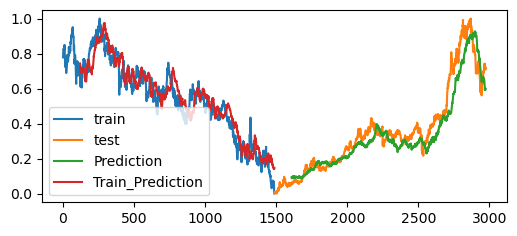

In [25]:
fig, ax = plt.subplots(figsize=(6, 2.5))
Normalized_Train_Data['Vale'].plot(ax=ax, label='train')
Normalized_Test_Data['Vale'].plot(ax=ax, label='test')
Res['Vale'].plot(ax=ax,label="Prediction")
Train_Res['Vale'].plot(ax=ax,label="Train_Prediction")
ax.legend();

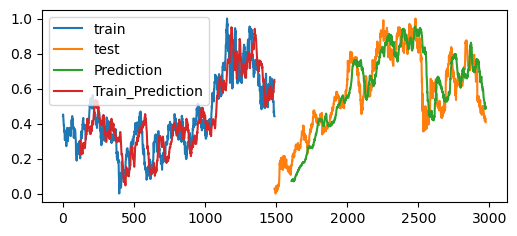

In [26]:
fig, ax = plt.subplots(figsize=(6, 2.5))
Normalized_Train_Data['Itau'].plot(ax=ax, label='train')
Normalized_Test_Data['Itau'].plot(ax=ax, label='test')
Res['Itau'].plot(ax=ax,label="Prediction")
Train_Res['Itau'].plot(ax=ax,label="Train_Prediction")
ax.legend();

In [29]:
Normalized_Train_Data.columns[0]


'Vale'

In [44]:
class TechnicalIndicators():
    def __init__(self, data_frame):
        self.df = data_frame.copy()

    def momentum(self, column, n, offset=0):
        if f'{column}_momentum_{n}*' not in self.df.columns:
            close_prices = self.df[column].iloc[offset:]
            momentum = close_prices / close_prices.shift(n) - 1
            momentum[0:n]=1
            self.df[f'{column}_momentum_{n}'] = momentum
            
        return self.df[f'{column}_momentum_{n}']

    def simple_movement_average(self, column, n, offset=0):
        if f'{column}_sma_{n}*' not in self.df.columns:
            window_mean = self.df[column].iloc[offset:].rolling(n).mean()
            window_mean[0:n]=  window_mean[n]
            self.df[f'{column}_sma_{n}'] = self.df[column] / window_mean - 1
        return self.df[f'{column}_sma_{n}']

    def _get_bollinger_bands(self, rm, rstd):
        upper_band = rm + rstd * 2
        lower_band = rm - rstd * 2
        return upper_band, lower_band

    def bollinger_bands(self, column, window_size=20, offset=0):
        if f'{column}_upper_band*' not in self.df.columns:
            self.df[f'{column}_mm20'] = self.df[column].iloc[offset:].rolling(window_size).mean()
            self.df[f'{column}_mm20'].iloc[0:window_size] =  self.df[f'{column}_mm20'].iloc[window_size]
            rstd = self.df[column].iloc[offset:].rolling(window_size).std()
            rstd.iloc[0:window_size] = rstd.iloc[window_size]
            self.df[f'{column}_upper_band'], self.df[f'{column}_lower_band'] = self._get_bollinger_bands(self.df[f'{column}_mm20'], rstd)
        return self.df[[column, f'{column}_mm20', f'{column}_upper_band', f'{column}_lower_band']]

    def add_daily_return(self,column):
        self.df[f'{column}_daily_return'] = (self.df[column] / self.df[column].shift(1)) - 1
        self.df[f'{column}_daily_return'].iloc[0] = 0
        self.df[f'{column}_cumulative_return'] = (self.df[column] / self.df[column].values[0]) - 1
        self.df[f'{column}_cumulative_return'].iloc[0] = 0

In [45]:
TF = TechnicalIndicators(Normalized_Train_Data)
print(TF.df)
print(type(TF.df))
for column in Normalized_Train_Data:
    print(TF.momentum(column,15))
    print(TF.simple_movement_average(column,15))
    print(TF.bollinger_bands(column,15))
    print(TF.add_daily_return(column))
print(TF.df)

          Vale      Itau
0     0.778071  0.443280
1     0.787991  0.451575
2     0.810726  0.440408
3     0.815273  0.427327
4     0.826021  0.408187
...        ...       ...
1483  0.058366  0.459892
1484  0.053751  0.470726
1485  0.028776  0.465567
1486  0.010044  0.440801
1487  0.000000  0.441317

[1488 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
0       1.000000
1       1.000000
2       1.000000
3       1.000000
4       1.000000
          ...   
1483    0.936939
1484    0.285716
1485   -0.502347
1486   -0.778442
1487   -1.000000
Name: Vale_momentum_15, Length: 1488, dtype: float64
0      -0.038973
1      -0.026720
2       0.001362
3       0.006978
4       0.020252
          ...   
1483    0.000932
1484   -0.090630
1485   -0.496677
1486   -0.816771
1487   -1.000000
Name: Vale_sma_15, Length: 1488, dtype: float64
          Vale  Vale_mm20  Vale_upper_band  Vale_lower_band
0     0.778071   0.809624         0.871401         0.747846
1     0.787991   0.809624         0.871401

/var/folders/k_/w3z0rb550bq5y149v61zw1lw0000gn/T/ipykernel_5581/298445011.py:29: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.df[f'{column}_mm20'].iloc[0:window_size] =  self.df[f'{column}_mm20'].iloc[window_size]
/var/folders/k_/w3z0r

In [30]:
import torch
from torch import nn
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))
print(h0,c0,hn,cn,output)

tensor([[[ 0.7745,  0.4343,  1.4099,  1.1551,  0.1578, -0.1577,  0.0996,
          -0.1124, -0.2155,  0.5270,  1.0725,  0.2909, -0.2294,  0.4480,
          -0.6031, -0.4086,  0.6309,  1.3045,  0.3944, -0.8046],
         [-2.4032,  1.2883, -0.4166, -1.4415,  0.4115, -2.1214, -0.2083,
           0.8484, -0.2738,  1.7497, -0.8297,  0.6128, -0.8419, -2.0686,
          -0.5655,  0.4144, -0.0490,  0.1306,  0.4594, -0.2675],
         [-2.3338, -1.5347, -0.4294,  0.7755, -1.0231,  0.6593, -1.4555,
           1.4865, -0.6935,  0.8728, -1.2591, -0.5578,  2.1372,  0.6331,
           0.7119,  2.7438, -2.3006,  1.1926,  1.3306, -0.4055]],

        [[-1.5376, -1.1052, -0.3170, -1.0523,  0.0416,  0.9759,  1.3003,
          -1.7049,  0.5096, -0.4493,  0.5843, -0.2624,  0.2268, -0.3941,
          -1.2826,  0.6774,  0.6528, -0.4138,  0.4246,  0.3071],
         [-0.9481, -1.7411, -1.0508,  0.4531, -0.5584, -0.5521, -0.9868,
          -0.1605, -0.7717, -1.2132, -0.3999,  2.4377, -0.0178,  0.0408,
        